**CASE STUDY: <br> AUTOMATION OF STANDBY DUTY PLANNING FOR RESCUE DRIVERS VIA A
FORECASTING MODEL**

Import necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta, date
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose

Import csv file to a dataframe abbreviated as df.

In [3]:
# Define function to read csv file into dataset
def read_csv_file(file): 
    dataset = pd.read_csv(file,header=0)
    return dataset
    
df = read_csv_file(r"C:\Users\nayma\anaconda3\Scripts\case_study\sickness_table.csv")

**Data understanding**

Explore the data and asses its quality. 

In [3]:
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


The first column is irrelevant.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


There is no missing data, some columns are not the appropiate type.

Format data to continue exploring.

In [4]:
# Change column Unnamed to Days
df = df.rename(columns={"Unnamed: 0": "days"})
df['days'] = df['days'] + 1

# Format the date
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d', errors = 'coerce')

# Make columns' values integers
for i in ['calls', 'sby_need', 'dafted']:
    df[i] = df[i].astype(int)

In [6]:
df.describe()

,days,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
mean,576.500000,2017-10-28 12:00:00,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
min,1.000000,2016-04-01 00:00:00,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,288.750000,2017-01-13 18:00:00,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,576.500000,2017-10-28 12:00:00,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,864.250000,2018-08-12 06:00:00,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000
max,1152.000000,2019-05-27 00:00:00,119.000000,11850.000000,1900.000000,90.0,555.000000,465.000000
std,332.698061,NaN,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089


n_sick ranges from 36 to 119 sick drivers. 
<br> Every day there are around 8000 calls, with a minimum of 4000 and a maximum of 118500 registered.
<br> The column n_duty needs further investigation.
<br> Every day there are 90 drivers in standby.
<br> Historically, there has been the need of additional drivers in less than half of the occasions. On average 35 drivers are needed but only on 25% of the cases the additional number of drivers required surpasses 12. In one occasion, 555 drivers where needed.
<br> The drafted column is the amount of drivers that were required in sby_need that could not be fullfilled with the 90 standby drivers in n_sby.

Investigating dafted.

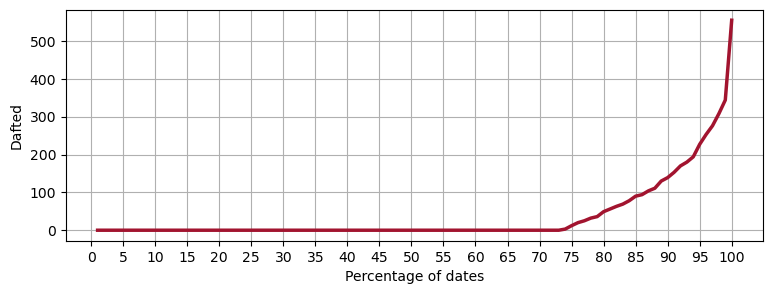

In [5]:
percentile_list = [i for i in range(1, 101)]
sby_need_percentile = []
for i in percentile_list:
    sby_need_percentile += [np.percentile(df.sby_need, i).round()]

plt.figure(figsize = (9,3))
plt.plot(percentile_list, sby_need_percentile, color="#A2142F", linewidth=2.5)
plt.xticks(np.arange(0, 101, 5))
plt.grid()
plt.xlabel('Percentage of dates')
plt.ylabel('Dafted')
plt.show()

In [8]:
objective = ((len(df.dafted) - df.dafted.astype(bool).sum(axis=0))/len(df.dafted)).round(2)
print("Percentage of times in which additional drivers were not needed", objective , ".")

Percentage of times in which additional drivers were not needed 0.85 .


In [16]:
for i in [2016, 2017, 2018, 2019]:
    filter = df.date.dt.year == i
    print("In ", i, " the percentage was", ((len(df[filter].dafted)- df[filter].dafted.astype(bool).sum(axis=0))/len(df[filter].dafted)).round(2), ".")

In  2016  the percentage was 0.89 .
In  2017  the percentage was 0.87 .
In  2018  the percentage was 0.86 .
In  2019  the percentage was 0.7 .


In [14]:
inactivated = df.n_sby - df.sby_need
inactivated[inactivated < 0] = 0
print("Number of inactivated standby drivers throughout the years: ",np.sum(inactivated), ".")

Number of inactivated standby drivers throughout the years:  82503 .


In [19]:
np.sum(df.n_sby)

103680

In [15]:
np.sum(df.n_sby) - np.sum(inactivated)

21177

In [11]:
print("Percentage of inactivated drivers throughout the years: ",round(np.sum(inactivated)/np.sum(df.n_sby), 2), ".")

Percentage of inactivated drivers throughout the years:  0.8 .


In [17]:
for i in [2016, 2017, 2018, 2019]:
    filter = df.date.dt.year == i
    inactivated = df[filter].n_sby - df[filter].sby_need
    inactivated[inactivated < 0] = 0
    print("Percentage of inactivated drivers throughout the years: ",round(np.sum(inactivated)/np.sum(df[filter].n_sby), 2), ".")

Percentage of inactivated drivers throughout the years:  0.82 .
Percentage of inactivated drivers throughout the years:  0.83 .
Percentage of inactivated drivers throughout the years:  0.81 .
Percentage of inactivated drivers throughout the years:  0.64 .


In [13]:
np.percentile(df.sby_need, 73.6).round()

0.0

Investigating n_duty.

In [13]:
df.n_duty.value_counts()

n_duty
1900    512
1800    365
1700    275
Name: count, dtype: int64

In [14]:
df.groupby(df.n_duty).first()['date']

n_duty
1700   2016-04-01
1800   2017-01-01
1900   2018-01-01
Name: date, dtype: datetime64[ns]

It seems that each year the number of drivers in duty has been increased by 100, with the exception of 2019.

Exploring the date column.

In [15]:
print("The dataframe seems to be ordered by dates. If this hypothesis is true, the first observation is from ", df['date'].loc[0].strftime('%Y-%m-%d'),
     " while the last is from", df['date'].loc[1151].strftime('%Y-%m-%d'),".")

The dataframe seems to be ordered by dates. If this hypothesis is true, the first observation is from  2016-04-01  while the last is from 2019-05-27 .


In [16]:
df.to_csv(r"C:\Users\nayma\anaconda3\Scripts\case_study\cleaned_data.csv", index= False)

**EDA** <br> Learn details about the
data, relationships, and
correlations between variables to gain a deeper
understanding of the d.ata

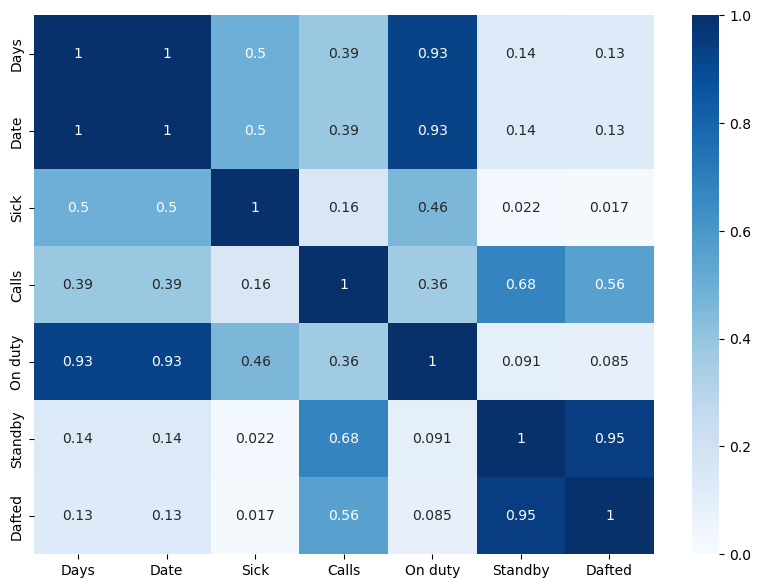

In [18]:
plt.figure(figsize = (10,7))
heatmap = sns.heatmap(df[['days','date','n_sick', 'calls', 'n_duty', 'sby_need', 'dafted']].rename(
    columns={'days':'Days','date':'Date','n_sick':'Sick', 'calls':'Calls', 'n_duty':'On duty', 'sby_need':'Standby','dafted':'Dafted'}).corr(), vmin=0, vmax=1, cmap="Blues", annot=True)

The correlation between sby_need and calls is surprising and the only really relevant. Contrary to the assumption, the number of sick on duty does not seem relevant to the sby_need.

array([[<Axes: xlabel='Days', ylabel='Days'>,
        <Axes: xlabel='Sick', ylabel='Days'>,
        <Axes: xlabel='Calls', ylabel='Days'>,
        <Axes: xlabel='On duty', ylabel='Days'>,
        <Axes: xlabel='Standby', ylabel='Days'>],
       [<Axes: xlabel='Days', ylabel='Sick'>,
        <Axes: xlabel='Sick', ylabel='Sick'>,
        <Axes: xlabel='Calls', ylabel='Sick'>,
        <Axes: xlabel='On duty', ylabel='Sick'>,
        <Axes: xlabel='Standby', ylabel='Sick'>],
       [<Axes: xlabel='Days', ylabel='Calls'>,
        <Axes: xlabel='Sick', ylabel='Calls'>,
        <Axes: xlabel='Calls', ylabel='Calls'>,
        <Axes: xlabel='On duty', ylabel='Calls'>,
        <Axes: xlabel='Standby', ylabel='Calls'>],
       [<Axes: xlabel='Days', ylabel='On duty'>,
        <Axes: xlabel='Sick', ylabel='On duty'>,
        <Axes: xlabel='Calls', ylabel='On duty'>,
        <Axes: xlabel='On duty', ylabel='On duty'>,
        <Axes: xlabel='Standby', ylabel='On duty'>],
       [<Axes: xlabel='Days'

<Figure size 1000x700 with 0 Axes>

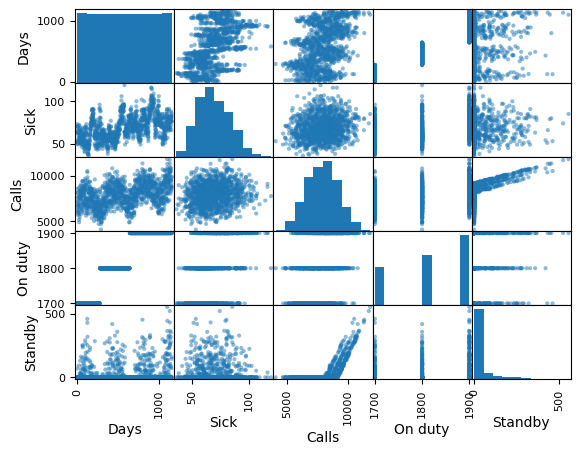

In [18]:
plt.figure(figsize = (10,7))
pd.plotting.scatter_matrix(
    df[['days','n_sick', 'calls', 'n_duty', 'sby_need']].rename(
        columns={'days':'Days','n_sick':'Sick', 'calls':'Calls', 'n_duty':'On duty', 'sby_need':'Standby'}))

Write about relationship between variables. <br> How sick nothing. <br> How calls seems reeeally important. Analyze further.

Text(0, 0.5, 'Standby activated')

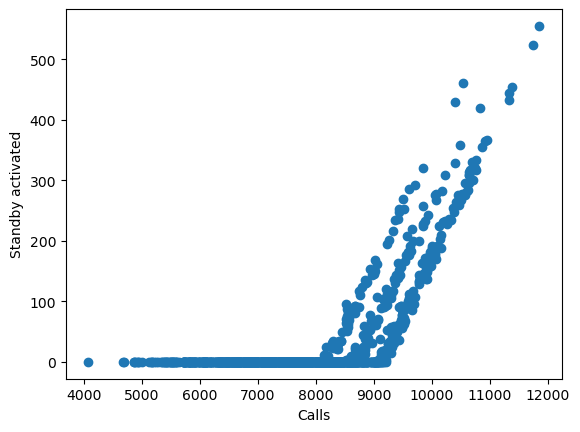

In [19]:
plt.scatter(df['calls'], df['sby_need'])
plt.xlabel('Calls')
plt.ylabel('Standby activated')

Time series.

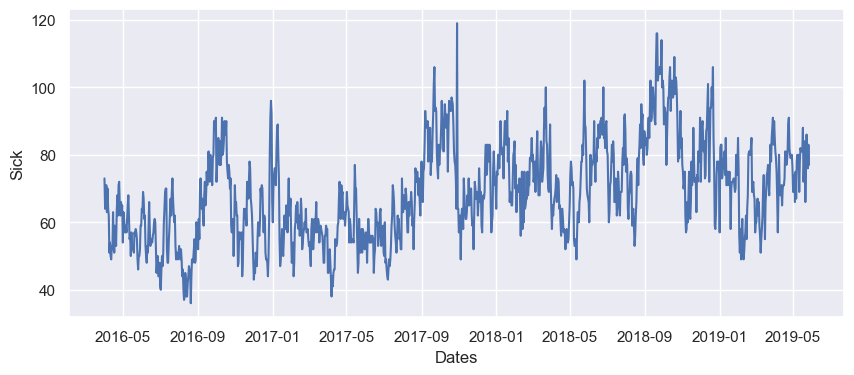

In [20]:
# Sick drivers
plt.figure(figsize=(10, 4))
sns.set()
plt.ylabel('Sick')
plt.xlabel('Dates')

plt.plot(df.date, df.n_sick)

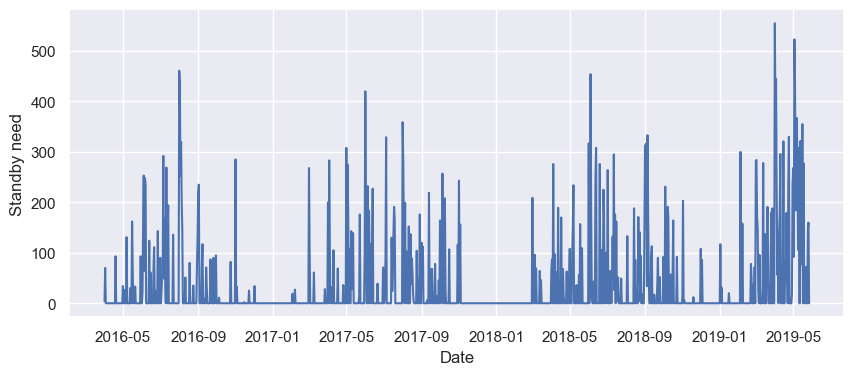

In [21]:
# Number standby drivers needed
plt.figure(figsize=(10, 4))
sns.set()
plt.ylabel('Standby need')
plt.xlabel('Date')
plt.plot(df.date, df.sby_need)

There seem to be clear spikes (technical name better) during summer.

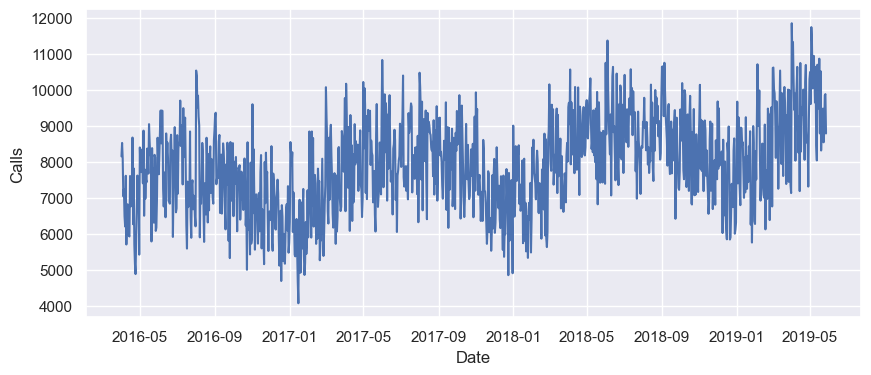

In [22]:
plt.figure(figsize=(10, 4))
sns.set()
plt.ylabel('Calls')
plt.xlabel('Date')
plt.plot(df.date, df.calls)

Decompose time series

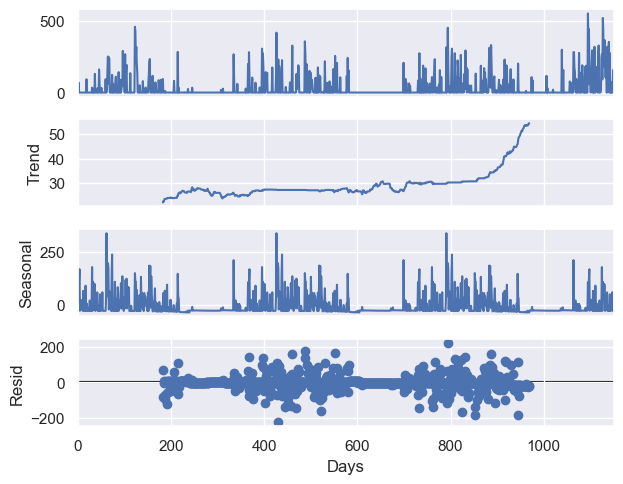

In [23]:
# Standby drivers per need
df['date'] = pd.to_numeric(pd.to_datetime(df['date']))
nresult = seasonal_decompose(df[['sby_need']], model='additive', period = 365)
nresult.plot()
plt.xlabel('Days')
plt.show()

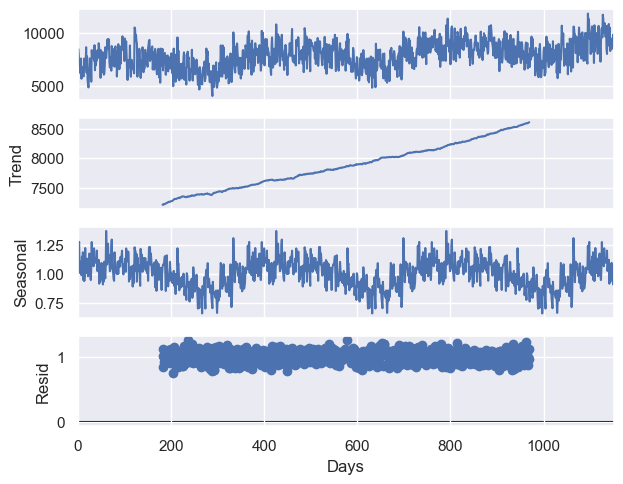

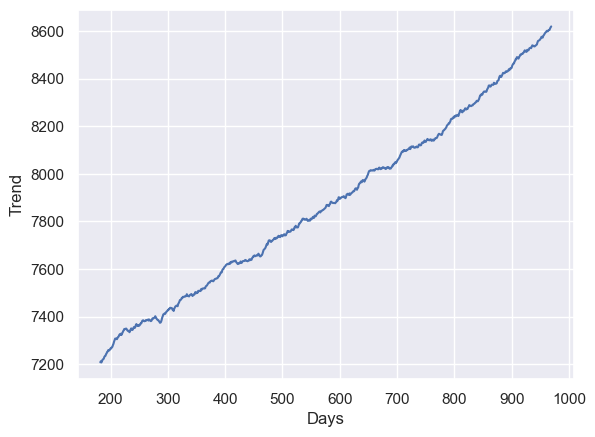

In [24]:
# Calls per year
df['date'] = pd.to_numeric(pd.to_datetime(df['date']))
nresult = seasonal_decompose(df[['calls']], model='multiplicative', period = 365)
nresult.plot()
plt.xlabel('Days')
plt.show()
nresult.trend.plot()

plt.xlabel('Days')
plt.ylabel('Trend')
plt.show()

<Figure size 1200x1000 with 0 Axes>

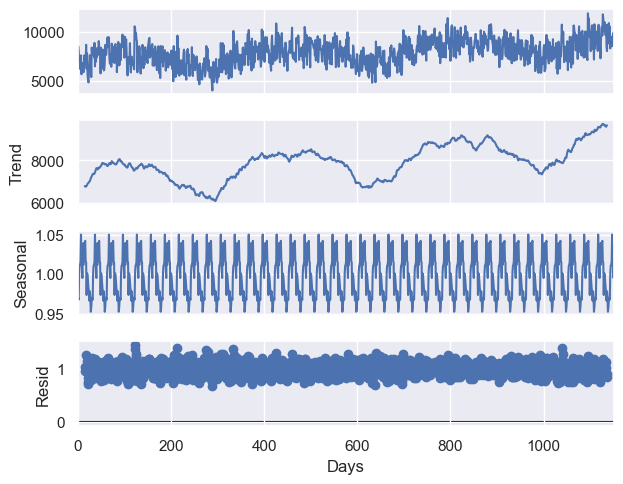

In [25]:
# Calls per month
plt.figure(figsize=(12, 10))
df['date'] = pd.to_numeric(pd.to_datetime(df['date']))
nresult = seasonal_decompose(df[['calls']], model='multiplicative', period = 30)
nresult.plot()
plt.xlabel('Days')
plt.show()

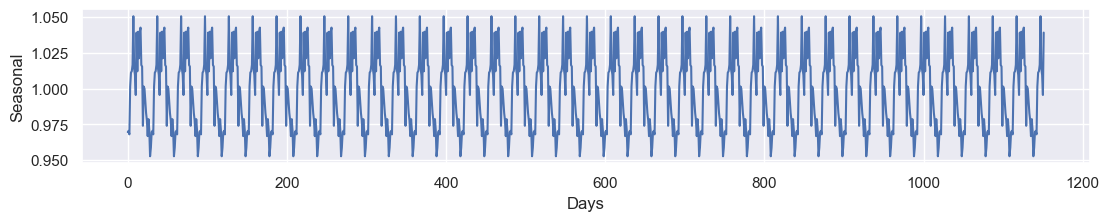

In [26]:
plt.figure(figsize=(13, 2))
nresult.seasonal.plot()
plt.ylabel('Seasonal')
plt.xlabel('Days')
plt.show()

There is 38,5 periods which correspond to the number of months.

Investigating correlations between calls and standby activated:

In [27]:
df['sby_need'].corr(df['calls']).round(2)

0.68

In [28]:
df[df.calls > 8136]['sby_need'].corr(df[df.calls > 8136]['calls']).round(2)

0.88

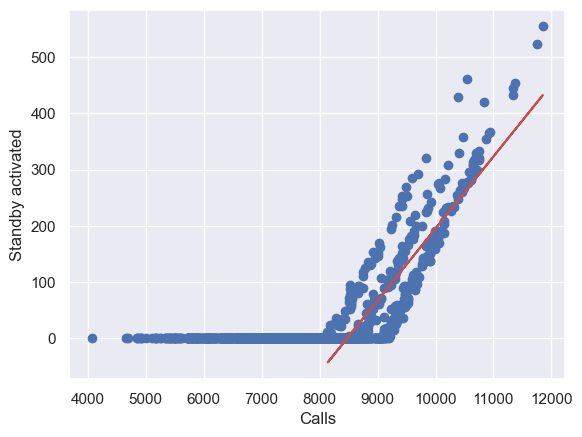

In [29]:
plt.scatter(df['calls'], df['sby_need'])
# Fit with polyfit

m, b = np.polyfit(df[df.calls > 8136]['calls'], df[df.calls > 8136]['sby_need'], 1)

plt.plot(df[df.calls > 8136]['calls'], b + m * df[df.calls > 8136]['calls'], 'r-')
plt.ylabel('Standby activated')
plt.xlabel('Calls')
plt.show()


In [30]:
print("m has value", m.round(2),", and b is", b.round(2))

m has value 0.13 , and b is -1088.47
